# Partial Dependence Plot

## Definition

The partial dependence plot(PDP) shows the marginal effect one or two features have on the predicted outcome of a machine learning model ( {cite}`friedman2001greedy` ).

In the probability theory, the marginal probability of random variable $X$ on $Y$ can be calculated by getting expectation on the joint distribution of random variables $X, Y$.

$$ f_X(x) = \Bbb{E}_Y\left[f_{X, Y}(x, y)\right] = \int_Y f_{X, Y}(x, y) f_Y(y) dy$$

Let's say the random variable that we concern is $X_s$, and the other variables are $X_c$, the partial dependence function is as follow:

$$f_{X_s}(x_S)=\Bbb{E}_{X_c}\left[f_{X_s, X_c}(x_s,x_c)\right]=\int f_{X_s, X_c}(x_s,x_c)f_{X_c}(x_c)dx_c$$

- $x_s$: the features that we care about
- $x_c$: other features
- $f$: probability function(or model)

## Implementation

The partial function $f_{X_s}(x_S)$ can be estimated by calculating averages in the training data, also known as Monte Carlo method:

$$f_{X_s}(x_S) = \dfrac{1}{n} \sum_{i=1}^n f_{X_s, X_c}(x_s,x_c^{(i)})$$

In [107]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import hvplot.pandas

from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

## Dataset: California Housing dataset

This dataset was obtained from the StatLib repository. https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

It was derived from the 1990 U.S. census, using one row per census block group. A block group is the smallest geographical unit for which the U.S. Census Bureau publishes sample data (a block group typically has a population of 600 to 3,000 people).

An household is a group of people residing within a home. Since the average number of rooms and bedrooms in this dataset are provided per household, these columns may take surpinsingly large values for block groups with few households and many empty houses, such as vacation resorts.

- References: https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset

| Columns | Explaination |
| --- | --- |
| MedHouseVal | The median house value for California districts, expressed in hundreds of thousands of dollars ($100,000).| 
| MedInc | median income in block group |
| HouseAge | median house age in block group |
| AveRooms | average number of rooms per household |
| AveBedrms | average number of bedrooms per household |
| Population | block group population |
| AveOccup | average number of household members |
| Latitude | block group latitude |
| Longitude | block group longitude |

In [102]:
house = fetch_california_housing()
df = pd.DataFrame(house['data'], columns=house['feature_names'])
df[house['target_names'][0]] = house['target']

In [103]:
df.hvplot.hist(y='MedHouseVal', bins=30, xlabel='Median House Value($100,000)', ylabel='Count', title='The Median House Value Distribution')

:Histogram   [MedHouseVal]   (MedHouseVal_count)

Prediction will use $R^2$ Score, which means [Coefficient of determination](https://en.wikipedia.org/wiki/Coefficient_of_determination)

$$R^2(y, \hat{y}) = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2}$$

where $\bar{y} = \frac{1}{n} \sum_{i=1}^{n} y_i$, $\sum_{i=1}^{n} (y_i - \hat{y}_i)^2 = \sum_{i=1}^{n} \epsilon_i^2$

In [106]:
seed = 7
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, :-1], df.iloc[:, -1], test_size=0.1, random_state=seed)
params = {
    'loss': 'squared_error',
    'learning_rate': 0.1,
    'n_estimators': 100,
    'random_state': seed,
    'max_depth': 5,
    'subsample': 1.0
}

model = GradientBoostingRegressor(**params)
model.fit(X_train, y_train)

# plot learning graph
test_score  = np.zeros((params["n_estimators"],), dtype=np.float64)

for i, y_pred in enumerate(model.staged_predict(X_test)):
    # model.loss_ assumes that y_test[i] in {0, 1}
    test_score[i] = model.loss_(y_test, y_pred)

# fig, ax = plt.subplots(1, 1, figsize=(12, 6))
df_results = pd.DataFrame(
    np.stack([model.train_score_, test_score]).T, columns=['Train', 'Test']
)
p_result = df_results.hvplot.line(
    xlabel='Boosting Iteration', ylabel='Deviance', group_label='Deviance', title='Deviance by boosting iteration',
    width=500, height=300, legend='top_right'
)

y_pred = model.predict(X_test)
print(f'The mean squared error (MSE) on test set is {mean_squared_error(y_true=y_test, y_pred=y_pred):.4f}')
print(f'The R2 Score on test set is {r2_score(y_true=y_test, y_pred=y_pred):.4f}')
p_result

The mean squared error (MSE) on test set is 0.2305
The R2 Score on test set is 0.8235


:NdOverlay   [Deviance]
   :Curve   [index]   (value)

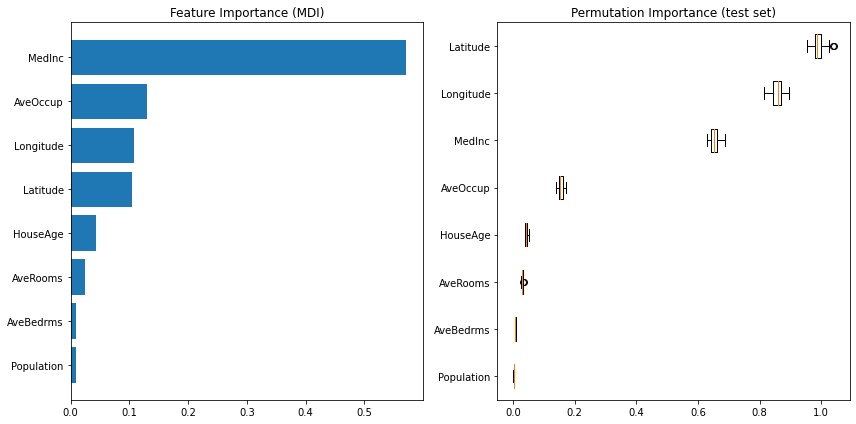

In [113]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(house.feature_names)[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    model, X_test, y_test, n_repeats=20, random_state=seed, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(house.feature_names)[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

In [119]:
model = GradientBoostingRegressor(**params)
model.fit(df.iloc[:, :-1], df.iloc[:, -1])
y_pred = model.predict(df.iloc[:, :-1])
print(f'The mean squared error (MSE) on test set is {mean_squared_error(y_true=df.iloc[:, -1], y_pred=y_pred):.4f}')
print(f'The R2 Score on test set is {r2_score(y_true=df.iloc[:, -1], y_pred=y_pred):.4f}')

The mean squared error (MSE) on test set is 0.1774
The R2 Score on test set is 0.8668


In [116]:
df.head(2)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.02381,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.97188,2401.0,2.109842,37.86,-122.22,3.585


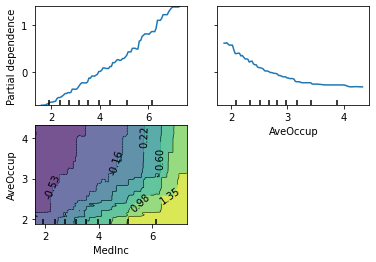

In [125]:
features = [0, 5, (0, 5)]
PartialDependenceDisplay.from_estimator(model, df, features=features, n_cols=2)

## References

- https://christophm.github.io/interpretable-ml-book/pdp.html
- https://scikit-learn.org/stable/modules/partial_dependence.html
- https://soohee410.github.io/iml_pdp